# Position Trading System
## Hold Period: 3-12 months | Target: 20-50% | Stop: 8-12%

**Strategy Philosophy:**
- Weekly charts (less noise than daily)
- Simple indicators (3-5 only)
- Breakout entries (not pullbacks)
- Trend following (ride strong moves)
- Wider stops (room to breathe)

**Best For:**
- Growth stocks (HIMS, SOFI, DDOG, NET, MDB)
- Stocks that trend 3-12 months
- Lower stress than swing trading
- Fewer trades, bigger gains

**Notebook Structure:**
1. Setup & Configuration
2. Position Trading Indicators (Simple)
3. Entry Signal Detection
4. Exit Management & Stops
5. Single Stock Analysis & Charts
6. Position Tracking Dashboard
7. Multi-Stock Scanner
8. Backtest Engine

---
## Cell 1: Setup & Configuration

In [ ]:
import sys
sys.path.append('../src')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from data_fetcher import StockDataFetcher
from indicators import sma, ema, atr, adx, roc, obv, mfi, vwap

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Position Trading Configuration
CONFIG = {
    'data_period': '5y',              # Need 5+ years for weekly analysis
    'interval': '1wk',                # Weekly data (key difference from swing)
    'risk_per_trade': 0.02,           # 2% account risk per trade
    'max_positions': 8,               # Max concurrent positions
    'target_gain': 0.30,              # 30% profit target
    'stop_loss_atr_mult': 2.5,        # 2.5x ATR for stop loss
    'trend_ma_short': 20,             # 20-week MA (short term)
    'trend_ma_long': 50,              # 50-week MA (long term)
    'volume_spike_threshold': 1.3,    # 1.3x avg volume = spike
    'min_adx': 25,                    # Minimum trend strength
    'min_roc': 10,                    # Minimum 10-week rate of change (%)
    'min_relative_strength': 1.0,     # Must outperform SPY
}

# Expanded Stock Universe - Test Many Tickers
WATCHLIST = [
    # Original Growth Stocks
    'HIMS',   # Healthcare/telehealth
    'SOFI',   # FinTech
    'DDOG',   # Cloud monitoring
    'NET',    # Cloud/edge computing
    'MDB',    # Database (MongoDB)
    'DOCS',   # Healthcare
    'DASH',   # Consumer/delivery
    'ABNB',   # Consumer/travel
    'OSCR',  
    'HIVE',   # Cloud security
    'NVDA',   # Semiconductors/AI
    
    # New Additions - Your Request
    'IREN',   # Bitcoin mining
    'MELI',   # Latin America e-commerce
    'AXA',    # Insurance (France)
    'MSTR',   # Bitcoin strategy/software
    'BBAI',   # AI decision intelligence
    'OUST',   # Lidar technology
    'ADBE',   # Adobe (software)
    'ROOT',   # Insurance tech
    'NBIS',   # Biotechnology
    'TSM',    # Semiconductor manufacturing
    'AIR',    # Aerospace/defense
    
    
    # Additional High-Quality Growth Stocks (expand testing)
    'CRWD',   # Cybersecurity
    'SNOW',   # Data cloud
    'PLTR',   # Data analytics/AI
    'SQ',     # FinTech (Block)
    'SHOP',   # E-commerce platform
    'COIN',   # Crypto exchange
    'RBLX',   # Gaming/metaverse
    'U',      # Unity (gaming engine)
    'RIVN',   # EV manufacturer
    'LCID',   # EV manufacturer
    'HOOD',   # FinTech trading
    'UPST',   # AI lending
    'AFRM',   # Buy now pay later
    'ZM',     # Video communications
    'DOCU',   # Digital agreements
]

print('Position Trading System - Setup Complete')
print(f'Configuration: {CONFIG["interval"]} data, {CONFIG["data_period"]} history')
print(f'Risk: {CONFIG["risk_per_trade"]*100}% per trade, Max {CONFIG["max_positions"]} positions')
print(f'Strategy: Breakout entries, {CONFIG["target_gain"]*100}% targets, {CONFIG["stop_loss_atr_mult"]}x ATR stops')
print(f'\nWatchlist: {len(WATCHLIST)} stocks to scan')
print(f'This gives you WAY more opportunities to find setups!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Position Trading System - Setup Complete
Configuration: 1wk data, 5y history
Risk: 2.0% per trade, Max 8 positions
Strategy: Breakout entries, 30.0% targets, 2.5x ATR stops

Watchlist: 36 stocks to scan
This gives you WAY more opportunities to find setups!


---
## Cell 2: Position Trading Indicators (Simple & Effective)

**Philosophy: Less is More**
- Only 3-5 indicators (not 15+)
- Weekly timeframe (less noise)
- Focus on trend and breakouts
- Volume confirmation critical

In [13]:
import yfinance as yf

def fetch_weekly_data(ticker, period='5y'):
    """
    Fetch weekly OHLCV data for position trading.
    Weekly data has less noise than daily.
    Uses yfinance directly to access weekly interval.
    """
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(period=period, interval='1wk')
        
        if df is None or df.empty:
            print(f'Failed to fetch data for {ticker}')
            return None
        
        # Ensure column names are consistent
        df.columns = df.columns.str.capitalize()
        
        print(f'Fetched {len(df)} weeks of data for {ticker}')
        return df
    
    except Exception as e:
        print(f'Error fetching {ticker}: {e}')
        return None


# Cache SPY data to avoid refetching for every stock
_SPY_CACHE = None

def get_spy_data():
    """
    Get SPY data once and cache it.
    """
    global _SPY_CACHE
    
    if _SPY_CACHE is None:
        try:
            spy = yf.Ticker('SPY')
            spy_df = spy.history(period='5y', interval='1wk')
            spy_df.columns = spy_df.columns.str.capitalize()
            _SPY_CACHE = spy_df
            print('Fetched SPY data for relative strength calculations')
        except Exception as e:
            print(f'Error fetching SPY: {e}')
            _SPY_CACHE = pd.DataFrame()
    
    return _SPY_CACHE


def calculate_relative_strength_vs_spy(df):
    """
    Calculate relative strength vs SPY (market).
    RS > 1.0 = outperforming market
    RS < 1.0 = underperforming market
    OPTIMIZED: Uses cached SPY data and shorter lookback
    """
    try:
        spy_df = get_spy_data()
        
        if spy_df.empty:
            return pd.Series([1.0] * len(df), index=df.index)  # Default to neutral
        
        # Calculate 10-week return for stock
        stock_return = df['Close'] / df['Close'].shift(10)
        
        # Align SPY data with stock dates
        spy_aligned = spy_df['Close'].reindex(df.index, method='ffill')
        spy_return = spy_aligned / spy_aligned.shift(10)
        
        # Relative strength = Stock return / SPY return
        rs = stock_return / spy_return
        
        # Fill NaN with 1.0 (neutral)
        rs = rs.fillna(1.0)
        
        return rs
    
    except Exception as e:
        # If error, return neutral (1.0) for all periods
        return pd.Series([1.0] * len(df), index=df.index)


def calculate_position_indicators(df, ticker=None):
    """
    Calculate enhanced indicators for position trading.
    OPTIMIZED: Less data loss from calculations.
    """
    df = df.copy()
    
    # Trend: Moving averages (weekly)
    df['SMA_20'] = sma(df['Close'], CONFIG['trend_ma_short'])
    df['SMA_50'] = sma(df['Close'], CONFIG['trend_ma_long'])
    
    # Trend strength
    adx_result = adx(df['High'], df['Low'], df['Close'], window=14)
    df['ADX'] = adx_result['ADX']
    df['Plus_DI'] = adx_result['Plus_DI']
    df['Minus_DI'] = adx_result['Minus_DI']
    
    # Volatility (for stop loss calculation)
    df['ATR'] = atr(df['High'], df['Low'], df['Close'], window=14)
    
    # Volume analysis
    df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_20']
    
    # Price structure (for breakout detection)
    df['High_52Week'] = df['High'].rolling(window=52).max()
    df['Low_52Week'] = df['Low'].rolling(window=52).min()
    df['High_20Week'] = df['High'].rolling(window=20).max()
    df['Low_20Week'] = df['Low'].rolling(window=20).min()
    
    # Distance from highs (for breakout proximity)
    df['Pct_From_52W_High'] = (df['Close'] - df['High_52Week']) / df['High_52Week'] * 100
    df['Pct_From_20W_High'] = (df['Close'] - df['High_20Week']) / df['High_20Week'] * 100
    
    # Trend alignment
    df['Trend_Bullish'] = (df['SMA_20'] > df['SMA_50']) & (df['Close'] > df['SMA_20'])
    df['Trend_Bearish'] = (df['SMA_20'] < df['SMA_50']) & (df['Close'] < df['SMA_20'])
    
    # NEW INDICATORS (Optimized for less data loss)
    
    # 1. Rate of Change (ROC) - Momentum confirmation
    df['ROC_10'] = roc(df['Close'], window=10)  # 10-week momentum
    
    # 2. On Balance Volume (OBV) - Cumulative volume trend
    df['OBV'] = obv(df['Close'], df['Volume'])
    df['OBV_SMA_20'] = df['OBV'].rolling(window=20).mean()
    df['OBV_Rising'] = df['OBV'] > df['OBV_SMA_20']
    
    # 3. Money Flow Index (MFI) - Volume-weighted momentum
    df['MFI'] = mfi(df['High'], df['Low'], df['Close'], df['Volume'], window=14)
    
    # 4. VWAP - Institutional support level
    df['VWAP'] = vwap(df['High'], df['Low'], df['Close'], df['Volume'])
    df['Above_VWAP'] = df['Close'] > df['VWAP']
    
    # 5. Relative Strength vs SPY (cached and optimized)
    df['RS_vs_SPY'] = calculate_relative_strength_vs_spy(df)
    df['Outperforming_Market'] = df['RS_vs_SPY'] > CONFIG['min_relative_strength']
    
    return df


print('Enhanced position trading indicators defined (OPTIMIZED)')
print('Original: SMA 20/50, ADX, ATR, Volume, 52W High/Low')
print('NEW ADDITIONS:')
print('  - ROC (momentum confirmation)')
print('  - OBV (cumulative volume trend)')
print('  - MFI (volume-weighted momentum)')
print('  - VWAP (institutional support)')
print('  - Relative Strength vs SPY (cached & optimized)')

Enhanced position trading indicators defined (OPTIMIZED)
Original: SMA 20/50, ADX, ATR, Volume, 52W High/Low
NEW ADDITIONS:
  - ROC (momentum confirmation)
  - OBV (cumulative volume trend)
  - MFI (volume-weighted momentum)
  - VWAP (institutional support)
  - Relative Strength vs SPY (cached & optimized)


---
## Cell 3: Entry Signal Detection

**Position Trading Entry Rules:**
1. **Breakout** - Price breaks above 20-week consolidation
2. **Trend** - 20W MA > 50W MA (uptrend established)
3. **Strength** - ADX > 25 (strong trend, not ranging)
4. **Volume** - Breakout on high volume (>1.3x average)
5. **Proximity** - Within 5% of 52-week high (strong stock)

**ALL criteria must be met for entry signal**

In [ ]:
def detect_breakout(df, lookback=20):
    """
    Detect breakout above recent consolidation.
    Breakout = close above highest high of last N weeks.
    """
    df = df.copy()
    
    # Consolidation high (exclude current week)
    df['Consolidation_High'] = df['High'].shift(1).rolling(window=lookback).max()
    
    # Breakout signal
    df['Breakout'] = df['Close'] > df['Consolidation_High']
    
    return df


def generate_entry_signal(df):
    """
    Generate ENHANCED position trading entry signal.
    Now includes momentum, volume trend, and market outperformance.
    """
    df = df.copy()
    
    # Detect breakouts
    df = detect_breakout(df, lookback=20)
    
    # Core entry criteria (ALL must be true)
    core_conditions = {
        'breakout': df['Breakout'],
        'trend_bullish': df['Trend_Bullish'],
        'strong_trend': df['ADX'] > CONFIG['min_adx'],
        'volume_spike': df['Volume_Ratio'] > CONFIG['volume_spike_threshold'],
        'near_highs': df['Pct_From_52W_High'] > -5,
    }
    
    # Enhancement criteria (improve signal quality)
    enhancement_conditions = {
        'strong_momentum': df['ROC_10'] > CONFIG['min_roc'],  # Strong momentum
        'accumulation': df['OBV_Rising'],  # Volume accumulation
        'mfi_bullish': df['MFI'] > 50,  # Money flowing in
        'above_vwap': df['Above_VWAP'],  # Above institutional average
        'outperforming': df['Outperforming_Market'],  # Beating market
    }
    
    # Combine CORE conditions (ALL required)
    df['Entry_Signal'] = True
    for condition_name, condition in core_conditions.items():
        df['Entry_Signal'] = df['Entry_Signal'] & condition
    
    # Store individual conditions for analysis
    for name, condition in core_conditions.items():
        df[f'Condition_{name}'] = condition
    
    for name, condition in enhancement_conditions.items():
        df[f'Enhancement_{name}'] = condition
    
    # Calculate enhancement score (0-5 points, one per enhancement)
    df['Enhancement_Score'] = sum([
        enhancement_conditions['strong_momentum'].astype(int),
        enhancement_conditions['accumulation'].astype(int),
        enhancement_conditions['mfi_bullish'].astype(int),
        enhancement_conditions['above_vwap'].astype(int),
        enhancement_conditions['outperforming'].astype(int),
    ])
    
    return df


def analyze_entry_signal(df, ticker):
    """
    Analyze current entry signal with ENHANCED metrics.
    """
    if df is None or df.empty:
        return
    
    latest = df.iloc[-1]
    
    print(f'\n{ticker} - Enhanced Entry Signal Analysis')
    print('=' * 70)
    
    # Current price info
    print(f'Current Price: ${latest["Close"]:.2f}')
    print(f'52-Week Range: ${latest["Low_52Week"]:.2f} - ${latest["High_52Week"]:.2f}')
    print(f'Distance from 52W High: {latest["Pct_From_52W_High"]:.1f}%')
    
    print(f'\nTrend Analysis:')
    print(f'  SMA 20W: ${latest["SMA_20"]:.2f}')
    print(f'  SMA 50W: ${latest["SMA_50"]:.2f}')
    print(f'  ADX (Trend Strength): {latest["ADX"]:.1f}')
    print(f'  Trend: {"BULLISH" if latest["Trend_Bullish"] else "BEARISH"}')
    
    print(f'\nVolume Analysis:')
    print(f'  Volume Ratio: {latest["Volume_Ratio"]:.2f}x')
    print(f'  OBV Rising: {"YES" if latest["OBV_Rising"] else "NO"}')
    
    print(f'\nMomentum & Strength:')
    print(f'  ROC (10W): {latest["ROC_10"]:.1f}%')
    print(f'  MFI: {latest["MFI"]:.1f}')
    print(f'  Above VWAP: {"YES" if latest["Above_VWAP"] else "NO"}')
    print(f'  RS vs SPY: {latest["RS_vs_SPY"]:.2f} ({"Outperforming" if latest["Outperforming_Market"] else "Underperforming"})')
    
    print(f'\n{"="*70}')
    print(f'CORE ENTRY CRITERIA (ALL must be YES):')
    core_conditions = [
        ('Breakout above 20W high', latest['Condition_breakout']),
        ('Bullish trend (20W > 50W)', latest['Condition_trend_bullish']),
        (f'Strong trend (ADX > {CONFIG["min_adx"]})', latest['Condition_strong_trend']),
        (f'Volume spike (>{CONFIG["volume_spike_threshold"]}x)', latest['Condition_volume_spike']),
        ('Near 52W high (<5% away)', latest['Condition_near_highs']),
    ]
    
    for condition_name, condition_met in core_conditions:
        status = 'YES' if condition_met else 'NO'
        symbol = '✓' if condition_met else '✗'
        print(f'  [{symbol}] {condition_name}: {status}')
    
    print(f'\nENHANCEMENT CRITERIA (bonus points):')
    enhancement_conditions = [
        (f'Strong momentum (ROC > {CONFIG["min_roc"]}%)', latest['Enhancement_strong_momentum']),
        ('Volume accumulation (OBV rising)', latest['Enhancement_accumulation']),
        ('Money flowing in (MFI > 50)', latest['Enhancement_mfi_bullish']),
        ('Above VWAP (institutional support)', latest['Enhancement_above_vwap']),
        ('Outperforming SPY (RS > 1.0)', latest['Enhancement_outperforming']),
    ]
    
    for condition_name, condition_met in enhancement_conditions:
        status = 'YES' if condition_met else 'NO'
        symbol = '+' if condition_met else '-'
        print(f'  [{symbol}] {condition_name}: {status}')
    
    enhancement_score = latest['Enhancement_Score']
    print(f'\nEnhancement Score: {enhancement_score}/5')
    
    # Final signal
    signal = latest['Entry_Signal']
    print(f'\n{"="*70}')
    if signal:
        print(f'ENTRY SIGNAL: STRONG BUY')
        if enhancement_score >= 4:
            print(f'QUALITY: EXCELLENT (4-5 enhancements met)')
        elif enhancement_score >= 3:
            print(f'QUALITY: VERY GOOD (3 enhancements met)')
        elif enhancement_score >= 2:
            print(f'QUALITY: GOOD (2 enhancements met)')
        else:
            print(f'QUALITY: FAIR (1 or fewer enhancements)')
        
        print(f'\nEntry Price: ${latest["Close"]:.2f}')
        stop_loss = latest['Close'] - (CONFIG['stop_loss_atr_mult'] * latest['ATR'])
        target = latest['Close'] * (1 + CONFIG['target_gain'])
        print(f'Stop Loss: ${stop_loss:.2f} ({CONFIG["stop_loss_atr_mult"]}x ATR)')
        print(f'Target: ${target:.2f} (+{CONFIG["target_gain"]*100:.0f}%)')
        print(f'Risk/Reward: 1:{(target - latest["Close"]) / (latest["Close"] - stop_loss):.2f}')
    else:
        print(f'ENTRY SIGNAL: NO SIGNAL')
        print(f'Status: Waiting for all CORE criteria to align')
        print(f'Enhancements Met: {enhancement_score}/5 (these are bonus, not required)')
    
    return signal


print('Enhanced entry signal detection functions defined')
print('Entry logic: Core criteria (5) + Enhancement criteria (5 bonus)')
print('Core = REQUIRED | Enhancements = IMPROVE quality')

Enhanced entry signal detection functions defined
Entry logic: Core criteria (5) + Enhancement criteria (5 bonus)
Core = REQUIRED | Enhancements = IMPROVE quality


---
## Cell 4: Exit Management & Stop Loss

**Position Trading Exit Rules:**
1. **Stop Loss** - Close below entry - (2.5x ATR)
2. **Profit Target** - +30% gain from entry
3. **Trailing Stop** - After +20%, trail 15% below highest close
4. **Trend Break** - Close below 20-week MA (trend no longer valid)
5. **Time Exit** - 52 weeks (1 year) maximum hold

**ANY exit trigger closes the position**

In [15]:
def calculate_stops_and_targets(df, entry_price=None, entry_date=None):
    """
    Calculate stop loss and profit targets for position.
    If no entry_price provided, use current price.
    """
    df = df.copy()
    
    if entry_price is None:
        entry_price = df['Close'].iloc[-1]
    
    if entry_date is None:
        entry_date = df.index[-1]
    
    # Initial stop loss (entry - 2.5x ATR)
    entry_atr = df.loc[entry_date, 'ATR'] if entry_date in df.index else df['ATR'].iloc[-1]
    initial_stop = entry_price - (CONFIG['stop_loss_atr_mult'] * entry_atr)
    
    # Profit target (+30%)
    profit_target = entry_price * (1 + CONFIG['target_gain'])
    
    # Trailing stop (15% below highest high after +20% gain)
    trailing_stop_threshold = entry_price * 1.20  # Activate at +20%
    trailing_stop_pct = 0.15  # Trail 15% below high
    
    # Calculate trailing stop for each bar after entry
    if entry_date in df.index:
        entry_idx = df.index.get_loc(entry_date)
        df['Position_High'] = df['Close'].iloc[entry_idx:].expanding().max()
        
        # Only apply trailing stop after +20% gain
        df['Trailing_Stop'] = np.where(
            df['Position_High'] >= trailing_stop_threshold,
            df['Position_High'] * (1 - trailing_stop_pct),
            initial_stop
        )
    else:
        df['Position_High'] = df['Close'].expanding().max()
        df['Trailing_Stop'] = initial_stop
    
    # Combine stops (use whichever is higher)
    df['Stop_Loss'] = np.maximum(initial_stop, df['Trailing_Stop'])
    df['Profit_Target'] = profit_target
    
    return df, initial_stop, profit_target


def detect_exit_signals(df, entry_price, entry_date):
    """
    Detect exit signals based on multiple criteria.
    """
    df = df.copy()
    
    # Calculate stops and targets
    df, initial_stop, profit_target = calculate_stops_and_targets(df, entry_price, entry_date)
    
    # Exit conditions
    df['Exit_Stop_Loss'] = df['Close'] < df['Stop_Loss']
    df['Exit_Profit_Target'] = df['Close'] >= df['Profit_Target']
    df['Exit_Trend_Break'] = ~df['Trend_Bullish']  # Close below 20W MA
    
    # Time-based exit (52 weeks = 1 year)
    if entry_date in df.index:
        entry_idx = df.index.get_loc(entry_date)
        weeks_in_position = np.arange(len(df)) - entry_idx
        df['Exit_Time'] = weeks_in_position >= 52
    else:
        df['Exit_Time'] = False
    
    # Combined exit signal (ANY condition triggers exit)
    df['Exit_Signal'] = (
        df['Exit_Stop_Loss'] |
        df['Exit_Profit_Target'] |
        df['Exit_Trend_Break'] |
        df['Exit_Time']
    )
    
    return df


def analyze_exit_signal(df, entry_price, entry_date, ticker):
    """
    Analyze current exit status for open position.
    """
    if df is None or df.empty:
        return
    
    df = detect_exit_signals(df, entry_price, entry_date)
    latest = df.iloc[-1]
    
    # Calculate position metrics
    current_price = latest['Close']
    gain_pct = (current_price - entry_price) / entry_price * 100
    
    if entry_date in df.index:
        entry_idx = df.index.get_loc(entry_date)
        weeks_held = len(df) - entry_idx - 1
    else:
        weeks_held = 0
    
    print(f'\n{ticker} - Position Exit Analysis')
    print('=' * 60)
    
    print(f'Position Status:')
    print(f'  Entry Price: ${entry_price:.2f}')
    print(f'  Current Price: ${current_price:.2f}')
    print(f'  Gain/Loss: {gain_pct:+.1f}%')
    print(f'  Weeks Held: {weeks_held}')
    
    print(f'\nExit Levels:')
    print(f'  Stop Loss: ${latest["Stop_Loss"]:.2f}')
    print(f'  Profit Target: ${latest["Profit_Target"]:.2f} (+{CONFIG["target_gain"]*100:.0f}%)')
    print(f'  20W MA: ${latest["SMA_20"]:.2f}')
    
    print(f'\nExit Triggers:')
    exit_conditions = [
        ('Stop loss hit', latest['Exit_Stop_Loss']),
        ('Profit target reached', latest['Exit_Profit_Target']),
        ('Trend break (below 20W MA)', latest['Exit_Trend_Break']),
        ('Time exit (52 weeks)', latest['Exit_Time']),
    ]
    
    for condition_name, triggered in exit_conditions:
        status = 'TRIGGERED' if triggered else 'Active'
        symbol = '!' if triggered else '-'
        print(f'  [{symbol}] {condition_name}: {status}')
    
    print(f'\n{"="*60}')
    if latest['Exit_Signal']:
        print(f'EXIT SIGNAL: CLOSE POSITION')
        # Determine which exit triggered
        if latest['Exit_Profit_Target']:
            print(f'Reason: Profit target reached (+{CONFIG["target_gain"]*100:.0f}%)')
        elif latest['Exit_Stop_Loss']:
            print(f'Reason: Stop loss hit')
        elif latest['Exit_Trend_Break']:
            print(f'Reason: Trend broken (below 20W MA)')
        elif latest['Exit_Time']:
            print(f'Reason: Time exit (52 weeks held)')
        print(f'Exit Price: ${current_price:.2f}')
        print(f'Total Return: {gain_pct:+.1f}%')
    else:
        print(f'EXIT SIGNAL: HOLD POSITION')
        print(f'Status: All exit criteria active, continue holding')
    
    return latest['Exit_Signal']


print('Exit management functions defined')
print('Exit logic: Stop Loss | Profit Target | Trailing Stop | Trend Break | Time')

Exit management functions defined
Exit logic: Stop Loss | Profit Target | Trailing Stop | Trend Break | Time


---
## Cell 5: Single Stock Analysis & Visualization

**Complete analysis workflow for one stock:**
1. Fetch weekly data
2. Calculate indicators
3. Generate entry/exit signals
4. Create 3-panel chart
5. Display detailed analysis

In [26]:
# Configuration: Change this to analyze different stocks
TICKER = 'AIR'

# Fetch data
print(f'Fetching weekly data for {TICKER}...')
df = fetch_weekly_data(TICKER, period=CONFIG['data_period'])

if df is not None and not df.empty:
    # Calculate indicators
    print('Calculating position trading indicators...')
    df = calculate_position_indicators(df)
    
    # Generate signals
    df = generate_entry_signal(df)
    
    # Drop rows with NaN (from indicator calculation)
    df = df.dropna()
    
    print(f'Analysis ready: {len(df)} weeks of data after indicator calculation')
    
    # Display analysis
    analyze_entry_signal(df, TICKER)
    
    # Store for charting
    analysis_df = df.copy()
else:
    print(f'Failed to fetch data for {TICKER}')

Fetching weekly data for AIR...
Fetched 262 weeks of data for AIR
Calculating position trading indicators...
Analysis ready: 211 weeks of data after indicator calculation

AIR - Enhanced Entry Signal Analysis
Current Price: $85.93
52-Week Range: $46.51 - $89.69
Distance from 52W High: -4.2%

Trend Analysis:
  SMA 20W: $76.32
  SMA 50W: $68.28
  ADX (Trend Strength): 51.5
  Trend: BULLISH

Volume Analysis:
  Volume Ratio: 0.45x
  OBV Rising: YES

Momentum & Strength:
  ROC (10W): 14.0%
  MFI: 68.5
  Above VWAP: YES
  RS vs SPY: 1.09 (Outperforming)

CORE ENTRY CRITERIA (ALL must be YES):
  [✗] Breakout above 20W high: NO
  [✓] Bullish trend (20W > 50W): YES
  [✓] Strong trend (ADX > 25): YES
  [✗] Volume spike (>1.3x): NO
  [✓] Near 52W high (<5% away): YES

ENHANCEMENT CRITERIA (bonus points):
  [+] Strong momentum (ROC > 10%): YES
  [+] Volume accumulation (OBV rising): YES
  [+] Money flowing in (MFI > 50): YES
  [+] Above VWAP (institutional support): YES
  [+] Outperforming SPY (RS

Chart saved to ../results/AIR_position_trading.png


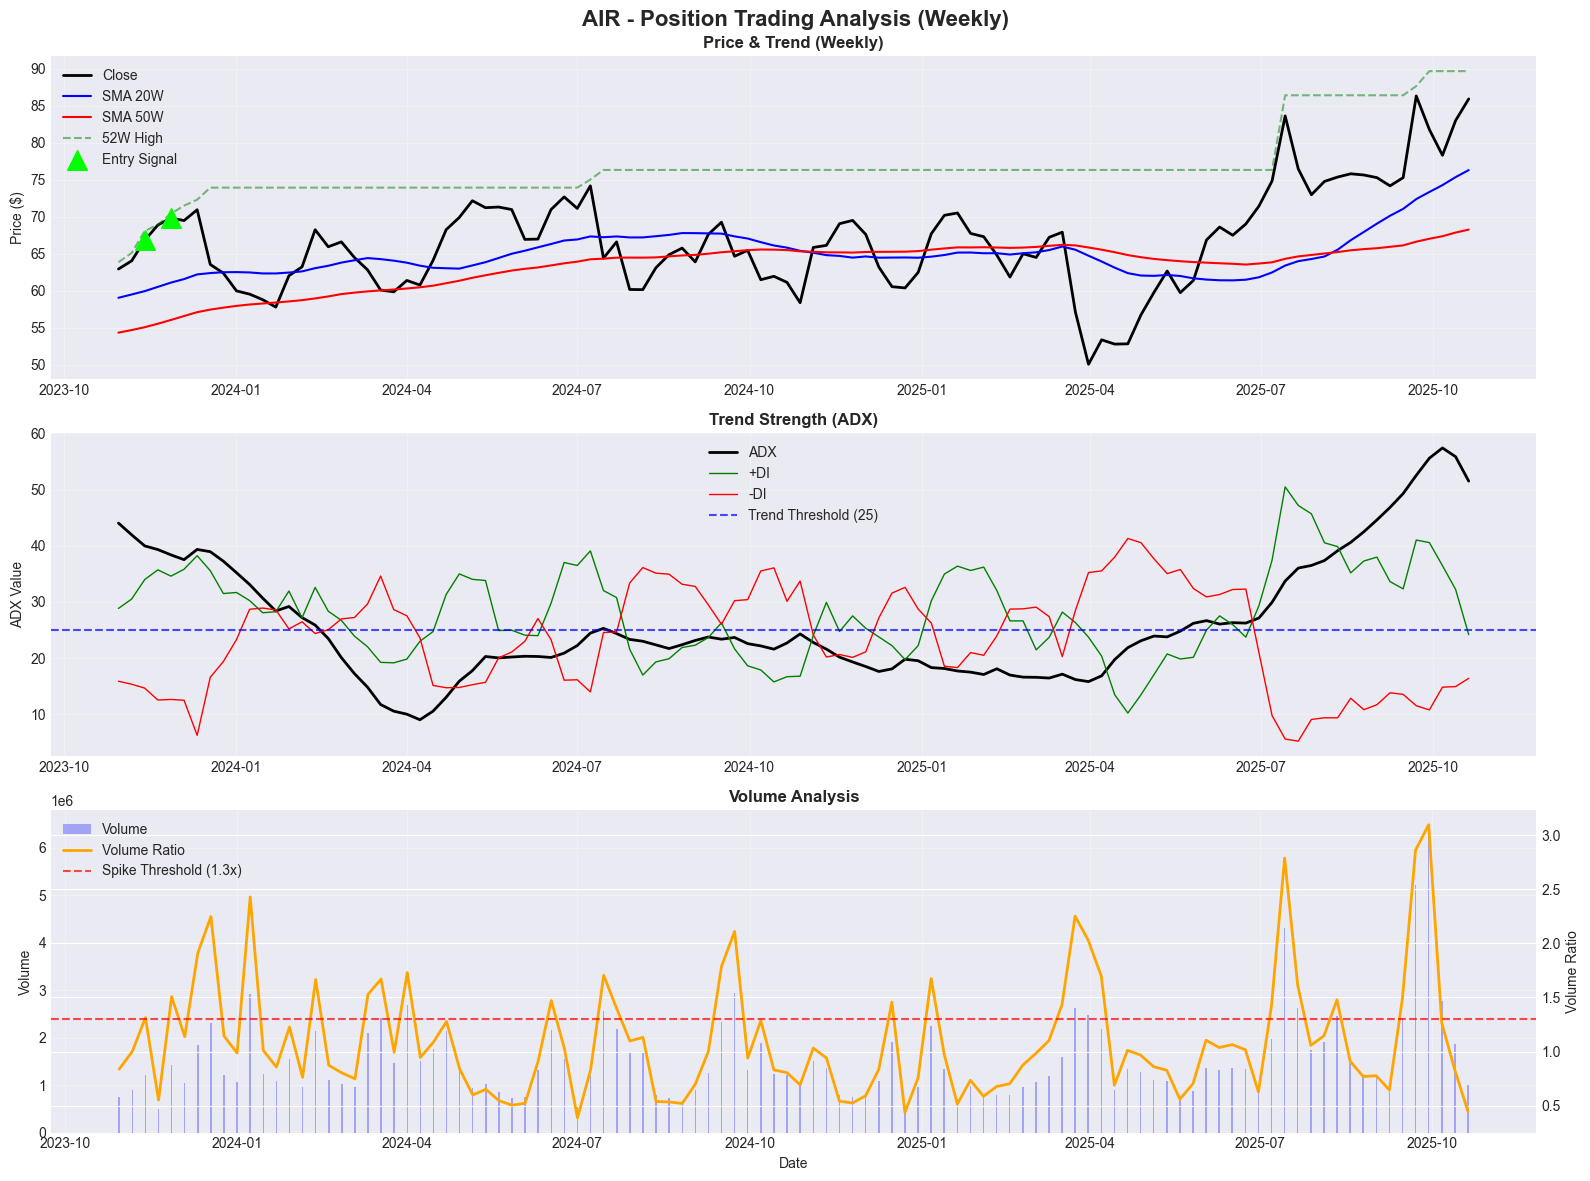

In [27]:
def create_position_trading_chart(df, ticker, save_path=None):
    """
    Create 3-panel weekly chart for position trading.
    Clean, professional, focused on trend and breakouts.
    """
    if df is None or df.empty:
        return
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    fig.suptitle(f'{ticker} - Position Trading Analysis (Weekly)', fontsize=16, fontweight='bold')
    
    # Get data for last 104 weeks (2 years) for better visibility
    plot_df = df.iloc[-104:].copy() if len(df) > 104 else df.copy()
    
    # Chart 1: Price with Moving Averages
    ax1 = axes[0]
    ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black', linewidth=2)
    ax1.plot(plot_df.index, plot_df['SMA_20'], label='SMA 20W', color='blue', linewidth=1.5)
    ax1.plot(plot_df.index, plot_df['SMA_50'], label='SMA 50W', color='red', linewidth=1.5)
    
    # Mark 52-week high
    ax1.plot(plot_df.index, plot_df['High_52Week'], label='52W High', 
             color='green', linestyle='--', alpha=0.5)
    
    # Highlight entry signals
    entry_signals = plot_df[plot_df['Entry_Signal']]
    if not entry_signals.empty:
        ax1.scatter(entry_signals.index, entry_signals['Close'], 
                   color='lime', marker='^', s=200, label='Entry Signal', zorder=5)
    
    ax1.set_title('Price & Trend (Weekly)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=10)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Chart 2: ADX - Trend Strength
    ax2 = axes[1]
    ax2.plot(plot_df.index, plot_df['ADX'], label='ADX', color='black', linewidth=2)
    ax2.plot(plot_df.index, plot_df['Plus_DI'], label='+DI', color='green', linewidth=1)
    ax2.plot(plot_df.index, plot_df['Minus_DI'], label='-DI', color='red', linewidth=1)
    ax2.axhline(y=CONFIG['min_adx'], color='blue', linestyle='--', 
                label=f'Trend Threshold ({CONFIG["min_adx"]})', alpha=0.7)
    ax2.set_title('Trend Strength (ADX)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('ADX Value', fontsize=10)
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    # Chart 3: Volume with Ratio
    ax3 = axes[2]
    ax3.bar(plot_df.index, plot_df['Volume'], color='blue', alpha=0.3, label='Volume')
    
    # Overlay volume ratio on secondary axis
    ax3_twin = ax3.twinx()
    ax3_twin.plot(plot_df.index, plot_df['Volume_Ratio'], 
                  color='orange', linewidth=2, label='Volume Ratio')
    ax3_twin.axhline(y=CONFIG['volume_spike_threshold'], color='red', 
                     linestyle='--', label=f'Spike Threshold ({CONFIG["volume_spike_threshold"]}x)', 
                     alpha=0.7)
    
    ax3.set_title('Volume Analysis', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Volume', fontsize=10)
    ax3_twin.set_ylabel('Volume Ratio', fontsize=10)
    
    # Combine legends
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='best')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f'Chart saved to {save_path}')
    
    plt.show()


# Create chart for analyzed stock
if 'analysis_df' in locals():
    create_position_trading_chart(
        analysis_df, 
        TICKER, 
        save_path=f'../results/{TICKER}_position_trading.png'
    )
else:
    print('No data available for charting')

---
## Cell 6: Position Tracking Dashboard

**Track all open and closed positions:**
- Manual entry of positions (for now)
- Track entry date, price, current value
- Monitor exit signals
- Calculate portfolio metrics

**Later: Can integrate with broker API for automatic tracking**

In [28]:
# Position tracking structure
# Manually enter your positions here
OPEN_POSITIONS = [
    # Example format:
    # {'ticker': 'HIMS', 'entry_date': '2024-10-01', 'entry_price': 15.50, 'shares': 100},
    # {'ticker': 'SOFI', 'entry_date': '2024-09-15', 'entry_price': 8.25, 'shares': 200},
]

CLOSED_POSITIONS = [
    # Example format:
    # {'ticker': 'DDOG', 'entry_date': '2024-01-15', 'entry_price': 100.00, 
    #  'exit_date': '2024-06-01', 'exit_price': 135.00, 'shares': 50, 'reason': 'Profit target'},
]


def analyze_open_positions(positions):
    """
    Analyze all open positions and check for exit signals.
    """
    if not positions:
        print('No open positions to analyze')
        return
    
    print('Open Positions Analysis')
    print('=' * 80)
    
    total_cost = 0
    total_value = 0
    
    for i, pos in enumerate(positions, 1):
        ticker = pos['ticker']
        entry_date = pd.to_datetime(pos['entry_date'])
        entry_price = pos['entry_price']
        shares = pos['shares']
        
        print(f'\nPosition {i}: {ticker}')
        print('-' * 80)
        
        # Fetch current data
        df = fetch_weekly_data(ticker, period=CONFIG['data_period'])
        
        if df is not None and not df.empty:
            df = calculate_position_indicators(df)
            df = df.dropna()
            
            # Get current price
            current_price = df['Close'].iloc[-1]
            
            # Calculate metrics
            cost_basis = entry_price * shares
            current_value = current_price * shares
            gain_loss = current_value - cost_basis
            gain_loss_pct = (current_price - entry_price) / entry_price * 100
            
            total_cost += cost_basis
            total_value += current_value
            
            # Display position info
            print(f'Entry: {entry_date.date()} @ ${entry_price:.2f} x {shares} shares')
            print(f'Current: ${current_price:.2f}')
            print(f'Cost Basis: ${cost_basis:,.2f}')
            print(f'Current Value: ${current_value:,.2f}')
            print(f'Gain/Loss: ${gain_loss:,.2f} ({gain_loss_pct:+.1f}%)')
            
            # Check exit signals
            print('\nExit Signal Check:')
            analyze_exit_signal(df, entry_price, entry_date, ticker)
        else:
            print(f'Failed to fetch data for {ticker}')
    
    # Portfolio summary
    if total_cost > 0:
        portfolio_gain_pct = (total_value - total_cost) / total_cost * 100
        print(f'\n{"="*80}')
        print(f'Portfolio Summary')
        print(f'Total Cost Basis: ${total_cost:,.2f}')
        print(f'Current Value: ${total_value:,.2f}')
        print(f'Total Gain/Loss: ${total_value - total_cost:,.2f} ({portfolio_gain_pct:+.1f}%)')
        print(f'Number of Positions: {len(positions)}')


def analyze_closed_positions(positions):
    """
    Analyze closed position performance.
    """
    if not positions:
        print('No closed positions to analyze')
        return
    
    print('\nClosed Positions Performance')
    print('=' * 80)
    
    wins = 0
    losses = 0
    total_return_pct = 0
    
    for i, pos in enumerate(positions, 1):
        entry_price = pos['entry_price']
        exit_price = pos['exit_price']
        shares = pos['shares']
        
        gain_loss = (exit_price - entry_price) * shares
        gain_loss_pct = (exit_price - entry_price) / entry_price * 100
        
        total_return_pct += gain_loss_pct
        
        if gain_loss > 0:
            wins += 1
            result = 'WIN'
        else:
            losses += 1
            result = 'LOSS'
        
        print(f'\nPosition {i}: {pos["ticker"]} - {result}')
        print(f'Entry: {pos["entry_date"]} @ ${entry_price:.2f}')
        print(f'Exit: {pos["exit_date"]} @ ${exit_price:.2f} ({pos["reason"]})')
        print(f'Return: ${gain_loss:,.2f} ({gain_loss_pct:+.1f}%)')
    
    # Performance summary
    total_trades = wins + losses
    if total_trades > 0:
        win_rate = wins / total_trades * 100
        avg_return = total_return_pct / total_trades
        
        print(f'\n{"="*80}')
        print(f'Performance Summary')
        print(f'Total Trades: {total_trades}')
        print(f'Wins: {wins} | Losses: {losses}')
        print(f'Win Rate: {win_rate:.1f}%')
        print(f'Average Return: {avg_return:+.1f}%')


# Run position analysis
analyze_open_positions(OPEN_POSITIONS)
analyze_closed_positions(CLOSED_POSITIONS)

No open positions to analyze
No closed positions to analyze


---
## Cell 7: Multi-Stock Scanner

**Scan watchlist for best position trading opportunities:**
- Fetch data for all stocks
- Calculate indicators and signals
- Rank by setup quality
- Display top opportunities

In [22]:
def scan_stocks_for_entries(tickers):
    """
    Scan multiple stocks for position trading entry signals.
    ENHANCED: Now shows enhancement score.
    """
    results = []
    
    print('Scanning stocks for position trading setups...')
    print('=' * 80)
    
    for ticker in tickers:
        print(f'\nAnalyzing {ticker}...')
        
        # Fetch and analyze
        df = fetch_weekly_data(ticker, period=CONFIG['data_period'])
        
        if df is None or df.empty:
            print(f'  Failed to fetch data for {ticker}')
            continue
        
        df = calculate_position_indicators(df, ticker=ticker)
        df = generate_entry_signal(df)
        df = df.dropna()
        
        if df.empty:
            print(f'  Insufficient data after calculations')
            continue
        
        latest = df.iloc[-1]
        
        # Calculate setup quality score (0-100)
        score = 0
        
        # Trend strength (0-40 points)
        if latest['ADX'] > 40:
            score += 40
        elif latest['ADX'] > 30:
            score += 30
        elif latest['ADX'] > CONFIG['min_adx']:
            score += 20
        
        # Volume (0-15 points)
        volume_score = min(latest['Volume_Ratio'] * 10, 15)
        score += volume_score
        
        # Proximity to 52W high (0-15 points)
        pct_from_high = latest['Pct_From_52W_High']
        if pct_from_high > -2:
            score += 15
        elif pct_from_high > -5:
            score += 10
        elif pct_from_high > -10:
            score += 5
        
        # Breakout (0-15 points)
        if latest['Condition_breakout']:
            score += 15
        
        # Enhancement score (0-15 points, 3 per enhancement)
        enhancement_score = latest['Enhancement_Score']
        score += enhancement_score * 3
        
        # Store results
        results.append({
            'Ticker': ticker,
            'Price': latest['Close'],
            'ADX': latest['ADX'],
            'Vol_Ratio': latest['Volume_Ratio'],
            'From_52W_High': latest['Pct_From_52W_High'],
            'Trend': 'BULLISH' if latest['Trend_Bullish'] else 'BEARISH',
            'Entry_Signal': latest['Entry_Signal'],
            'Enhancements': f"{int(enhancement_score)}/5",
            'Score': score,
        })
        
        print(f'  Price: ${latest["Close"]:.2f} | ADX: {latest["ADX"]:.1f} | Enhancements: {int(enhancement_score)}/5 | Score: {score:.0f}')
    
    # Create results dataframe
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Score', ascending=False)
        return results_df
    else:
        return pd.DataFrame()


# Run scanner
print('Position Trading Scanner (ENHANCED)')
print(f'Scanning {len(WATCHLIST)} stocks')
print()

scanner_results = scan_stocks_for_entries(WATCHLIST)

if not scanner_results.empty:
    print('\n' + '='*80)
    print('Scanner Results (Ranked by Setup Quality)')
    print('='*80)
    
    # Format display
    display_df = scanner_results.copy()
    display_df['Price'] = display_df['Price'].apply(lambda x: f'${x:.2f}')
    display_df['ADX'] = display_df['ADX'].apply(lambda x: f'{x:.1f}')
    display_df['Vol_Ratio'] = display_df['Vol_Ratio'].apply(lambda x: f'{x:.2f}x')
    display_df['From_52W_High'] = display_df['From_52W_High'].apply(lambda x: f'{x:.1f}%')
    display_df['Entry_Signal'] = display_df['Entry_Signal'].apply(lambda x: 'BUY' if x else '-')
    display_df['Score'] = display_df['Score'].apply(lambda x: f'{x:.0f}')
    
    print(display_df.to_string(index=False))
    
    # Interpretation guide
    print('\nInterpretation:')
    print('  Score 80-100: Excellent setup (strong trend + breakout + enhancements)')
    print('  Score 60-79:  Good setup (most criteria met)')
    print('  Score 40-59:  Fair setup (developing)')
    print('  Score <40:    Weak setup (wait for better entry)')
    print('\nEnhancements (bonus criteria):')
    print('  5/5: Perfect setup - all enhancements met')
    print('  3-4/5: Strong setup - most enhancements met')
    print('  1-2/5: Fair setup - some enhancements met')
    print('  0/5: Basic setup - only core criteria')
    print('\nRecommendation: Focus on stocks with Score > 60 AND Entry_Signal = BUY')
    
    # Top opportunities
    top_setups = scanner_results[(scanner_results['Score'] > 60) & (scanner_results['Entry_Signal'])]
    if not top_setups.empty:
        print(f'\nTOP OPPORTUNITIES ({len(top_setups)} stocks):')
        for _, row in top_setups.iterrows():
            print(f"  {row['Ticker']}: Score {row['Score']:.0f} | Enhancements {row['Enhancements']} | ${row['Price']:.2f}")
    else:
        print('\nNo high-quality entry signals at this time')
        
        # Show best developing setups
        developing = scanner_results.head(5)
        print(f'\nBest Developing Setups (watch these):')
        for _, row in developing.iterrows():
            print(f"  {row['Ticker']}: Score {row['Score']:.0f} | Enhancements {row['Enhancements']} | Trend: {row['Trend']}")
else:
    print('No results from scanner')

Position Trading Scanner (ENHANCED)
Scanning 36 stocks

Scanning stocks for position trading setups...

Analyzing HIMS...
Fetched 262 weeks of data for HIMS
  Price: $47.45 | ADX: 21.6 | Enhancements: 2/5 | Score: 12

Analyzing SOFI...
Fetched 251 weeks of data for SOFI
  Price: $28.31 | ADX: 73.5 | Enhancements: 5/5 | Score: 67

Analyzing DDOG...
Fetched 262 weeks of data for DDOG
  Price: $154.60 | ADX: 51.0 | Enhancements: 4/5 | Score: 60

Analyzing NET...
Fetched 262 weeks of data for NET
  Price: $216.71 | ADX: 54.2 | Enhancements: 4/5 | Score: 62

Analyzing MDB...
Fetched 262 weeks of data for MDB
  Price: $328.10 | ADX: 61.4 | Enhancements: 5/5 | Score: 58

Analyzing DOCS...
Fetched 227 weeks of data for DOCS
  Price: $66.40 | ADX: 48.1 | Enhancements: 3/5 | Score: 53

Analyzing DASH...
Fetched 255 weeks of data for DASH
  Price: $251.78 | ADX: 54.7 | Enhancements: 2/5 | Score: 53

Analyzing ABNB...
Fetched 255 weeks of data for ABNB
  Price: $127.83 | ADX: 24.9 | Enhancements: 

$AXA: possibly delisted; no price data found  (period=5y)


Fetched 206 weeks of data for IREN
  Price: $55.47 | ADX: 79.5 | Enhancements: 5/5 | Score: 64

Analyzing MELI...
Fetched 262 weeks of data for MELI
  Price: $2101.17 | ADX: 22.1 | Enhancements: 1/5 | Score: 9

Analyzing AXA...
Failed to fetch data for AXA
  Failed to fetch data for AXA

Analyzing MSTR...
Fetched 262 weeks of data for MSTR
  Price: $286.77 | ADX: 24.6 | Enhancements: 1/5 | Score: 10

Analyzing BBAI...
Fetched 238 weeks of data for BBAI
  Price: $6.66 | ADX: 36.4 | Enhancements: 4/5 | Score: 50

Analyzing OUST...
Fetched 262 weeks of data for OUST
  Price: $32.34 | ADX: 67.1 | Enhancements: 3/5 | Score: 55

Analyzing ADBE...
Fetched 262 weeks of data for ADBE
  Price: $351.32 | ADX: 30.6 | Enhancements: 0/5 | Score: 36

Analyzing ROOT...
Fetched 261 weeks of data for ROOT
  Price: $78.84 | ADX: 29.2 | Enhancements: 0/5 | Score: 25

Analyzing NBIS...
Fetched 53 weeks of data for NBIS
  Price: $103.76 | ADX: 65.3 | Enhancements: 5/5 | Score: 65

Analyzing TSM...
Fetched 2

$SQ: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


Failed to fetch data for SQ
  Failed to fetch data for SQ

Analyzing SHOP...
Fetched 262 weeks of data for SHOP
  Price: $166.15 | ADX: 62.1 | Enhancements: 5/5 | Score: 71

Analyzing COIN...
Fetched 237 weeks of data for COIN
  Price: $322.24 | ADX: 31.3 | Enhancements: 1/5 | Score: 38

Analyzing RBLX...
Fetched 242 weeks of data for RBLX
  Price: $129.73 | ADX: 66.0 | Enhancements: 5/5 | Score: 59

Analyzing U...
Fetched 262 weeks of data for U
  Price: $36.21 | ADX: 56.3 | Enhancements: 2/5 | Score: 51

Analyzing RIVN...
Fetched 207 weeks of data for RIVN
  Price: $12.98 | ADX: 13.4 | Enhancements: 3/5 | Score: 15

Analyzing LCID...
Fetched 262 weeks of data for LCID
  Price: $18.66 | ADX: 13.6 | Enhancements: 0/5 | Score: 4

Analyzing HOOD...
Fetched 222 weeks of data for HOOD
  Price: $133.49 | ADX: 62.1 | Enhancements: 5/5 | Score: 60

Analyzing UPST...
Fetched 254 weeks of data for UPST
  Price: $51.57 | ADX: 35.0 | Enhancements: 0/5 | Score: 37

Analyzing AFRM...
Fetched 250 we

---
## Cell 8: Backtest Engine

**Validate the strategy on historical data:**
- Test entry/exit rules on past data
- Calculate win rate, avg return, max drawdown
- Prove the strategy works before risking real money

**Critical: This tells you if the strategy is profitable**

In [24]:
def backtest_position_trading(ticker, start_date=None, end_date=None, show_details=False):
    """
    Backtest position trading strategy on historical data.
    Walk-forward through time and simulate trades.
    """
    if show_details:
        print(f'\nBacktesting {ticker}')
        print('=' * 80)
    
    # Fetch full history
    df = fetch_weekly_data(ticker, period='10y')  # 10 years for robust backtest
    
    if df is None or df.empty:
        if show_details:
            print(f'Failed to fetch data for {ticker}')
        return None
    
    # Calculate indicators
    df = calculate_position_indicators(df, ticker=ticker)
    df = generate_entry_signal(df)
    df = df.dropna()
    
    if df.empty:
        if show_details:
            print('Insufficient data for backtest')
        return None
    
    # Filter date range if specified
    if start_date:
        df = df[df.index >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df.index <= pd.to_datetime(end_date)]
    
    if show_details:
        print(f'Testing period: {df.index[0].date()} to {df.index[-1].date()}')
        print(f'Data points: {len(df)} weeks')
    
    # Simulate trading
    trades = []
    in_position = False
    entry_price = 0
    entry_date = None
    entry_idx = 0
    
    for i in range(len(df)):
        current_date = df.index[i]
        current_bar = df.iloc[i]
        
        if not in_position:
            # Look for entry signal
            if current_bar['Entry_Signal']:
                # Enter position
                in_position = True
                entry_price = current_bar['Close']
                entry_date = current_date
                entry_idx = i
                
                # Calculate stops and targets
                initial_stop = entry_price - (CONFIG['stop_loss_atr_mult'] * current_bar['ATR'])
                profit_target = entry_price * (1 + CONFIG['target_gain'])
        
        else:
            # Check exit conditions
            weeks_held = i - entry_idx
            current_price = current_bar['Close']
            
            # Calculate trailing stop
            position_high = df['Close'].iloc[entry_idx:i+1].max()
            trailing_stop_active = position_high >= entry_price * 1.20
            trailing_stop = position_high * (1 - 0.15) if trailing_stop_active else initial_stop
            stop_loss = max(initial_stop, trailing_stop)
            
            # Check exit triggers
            exit_reason = None
            exit_price = current_price
            
            if current_price >= profit_target:
                exit_reason = 'Profit Target'
                exit_price = profit_target
            elif current_price < stop_loss:
                exit_reason = 'Stop Loss'
                exit_price = stop_loss
            elif not current_bar['Trend_Bullish']:
                exit_reason = 'Trend Break'
            elif weeks_held >= 52:
                exit_reason = 'Time Exit'
            
            if exit_reason:
                # Exit position
                exit_date = current_date
                return_pct = (exit_price - entry_price) / entry_price * 100
                
                trades.append({
                    'Entry_Date': entry_date,
                    'Entry_Price': entry_price,
                    'Exit_Date': exit_date,
                    'Exit_Price': exit_price,
                    'Return_Pct': return_pct,
                    'Weeks_Held': weeks_held,
                    'Exit_Reason': exit_reason,
                })
                
                in_position = False
    
    # Analyze results
    if not trades:
        if show_details:
            print('No trades generated during backtest period')
        return None
    
    trades_df = pd.DataFrame(trades)
    
    # Calculate metrics
    total_trades = len(trades_df)
    winning_trades = trades_df[trades_df['Return_Pct'] > 0]
    losing_trades = trades_df[trades_df['Return_Pct'] <= 0]
    
    win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
    avg_win = winning_trades['Return_Pct'].mean() if len(winning_trades) > 0 else 0
    avg_loss = losing_trades['Return_Pct'].mean() if len(losing_trades) > 0 else 0
    avg_return = trades_df['Return_Pct'].mean()
    total_return = trades_df['Return_Pct'].sum()
    max_win = trades_df['Return_Pct'].max()
    max_loss = trades_df['Return_Pct'].min()
    avg_hold_time = trades_df['Weeks_Held'].mean()
    
    # Profit factor
    total_gains = winning_trades['Return_Pct'].sum() if len(winning_trades) > 0 else 0
    total_losses = abs(losing_trades['Return_Pct'].sum()) if len(losing_trades) > 0 else 1
    profit_factor = total_gains / total_losses if total_losses > 0 else 0
    
    # Display detailed results if requested
    if show_details:
        print(f'\nBacktest Results for {ticker}')
        print('=' * 80)
        print(f'Total Trades: {total_trades}')
        print(f'Winning Trades: {len(winning_trades)} ({win_rate:.1f}%)')
        print(f'Losing Trades: {len(losing_trades)}')
        print(f'\nReturns:')
        print(f'  Average Return per Trade: {avg_return:+.2f}%')
        print(f'  Total Return (sum of all trades): {total_return:+.2f}%')
        print(f'  Average Win: {avg_win:+.2f}%')
        print(f'  Average Loss: {avg_loss:+.2f}%')
        print(f'  Max Win: {max_win:+.2f}%')
        print(f'  Max Loss: {max_loss:+.2f}%')
        print(f'\nMetrics:')
        print(f'  Profit Factor: {profit_factor:.2f}')
        print(f'  Average Hold Time: {avg_hold_time:.1f} weeks')
        
        # Exit reasons breakdown
        print(f'\nExit Reasons:')
        exit_counts = trades_df['Exit_Reason'].value_counts()
        for reason, count in exit_counts.items():
            pct = count / total_trades * 100
            print(f'  {reason}: {count} ({pct:.1f}%)')
    
    # Return summary metrics
    return {
        'Ticker': ticker,
        'Trades': total_trades,
        'Win_Rate': win_rate,
        'Avg_Return': avg_return,
        'Total_Return': total_return,
        'Profit_Factor': profit_factor,
        'Avg_Win': avg_win,
        'Avg_Loss': avg_loss,
        'Max_Win': max_win,
        'Max_Loss': max_loss,
        'Avg_Hold_Weeks': avg_hold_time,
    }


print('='*80)
print('COMPREHENSIVE BACKTEST - ALL STOCKS')
print('='*80)
print(f'Testing strategy on {len(WATCHLIST)} stocks...')
print('This will take a few minutes...\n')

# Run backtest on ALL stocks
all_results = []
successful_backtests = 0
failed_backtests = 0

for i, ticker in enumerate(WATCHLIST, 1):
    print(f'[{i}/{len(WATCHLIST)}] Backtesting {ticker}...', end=' ')
    
    result = backtest_position_trading(ticker, show_details=False)
    
    if result is not None:
        all_results.append(result)
        successful_backtests += 1
        print(f'✓ {result["Trades"]} trades, {result["Win_Rate"]:.1f}% win rate')
    else:
        failed_backtests += 1
        print(f'✗ Failed (insufficient data)')

print(f'\n{"="*80}')
print(f'Backtest Complete: {successful_backtests} successful, {failed_backtests} failed')
print('='*80)

# Create summary dataframe
if all_results:
    summary_df = pd.DataFrame(all_results)
    
    # Sort by total return
    summary_df = summary_df.sort_values('Total_Return', ascending=False)
    
    print('\nBACKTEST RESULTS - ALL STOCKS (Sorted by Total Return)')
    print('='*80)
    
    # Format for display
    display_summary = summary_df.copy()
    display_summary['Trades'] = display_summary['Trades'].apply(lambda x: f'{x}')
    display_summary['Win_Rate'] = display_summary['Win_Rate'].apply(lambda x: f'{x:.1f}%')
    display_summary['Avg_Return'] = display_summary['Avg_Return'].apply(lambda x: f'{x:+.2f}%')
    display_summary['Total_Return'] = display_summary['Total_Return'].apply(lambda x: f'{x:+.1f}%')
    display_summary['Profit_Factor'] = display_summary['Profit_Factor'].apply(lambda x: f'{x:.2f}')
    
    # Select key columns for display
    display_cols = ['Ticker', 'Trades', 'Win_Rate', 'Avg_Return', 'Total_Return', 'Profit_Factor']
    print(display_summary[display_cols].to_string(index=False))
    
    # Overall statistics
    print(f'\n{"="*80}')
    print('OVERALL PERFORMANCE ACROSS ALL STOCKS')
    print('='*80)
    
    total_trades_all = summary_df['Trades'].sum()
    avg_win_rate = summary_df['Win_Rate'].mean()
    avg_return_per_trade = summary_df['Avg_Return'].mean()
    median_return = summary_df['Avg_Return'].median()
    avg_profit_factor = summary_df['Profit_Factor'].mean()
    
    # Count profitable vs unprofitable stocks
    profitable_stocks = len(summary_df[summary_df['Total_Return'] > 0])
    unprofitable_stocks = len(summary_df[summary_df['Total_Return'] <= 0])
    
    print(f'Total Stocks Tested: {len(summary_df)}')
    print(f'Profitable Stocks: {profitable_stocks} ({profitable_stocks/len(summary_df)*100:.1f}%)')
    print(f'Unprofitable Stocks: {unprofitable_stocks} ({unprofitable_stocks/len(summary_df)*100:.1f}%)')
    print(f'Total Trades (All Stocks): {total_trades_all}')
    print(f'\nAverage Metrics:')
    print(f'  Average Win Rate: {avg_win_rate:.1f}%')
    print(f'  Average Return per Trade: {avg_return_per_trade:+.2f}%')
    print(f'  Median Return per Trade: {median_return:+.2f}%')
    print(f'  Average Profit Factor: {avg_profit_factor:.2f}')
    
    # Best and worst performers
    print(f'\n{"="*80}')
    print('TOP 5 PERFORMERS (by Total Return)')
    print('='*80)
    top_5 = summary_df.head(5)
    for _, row in top_5.iterrows():
        print(f"  {row['Ticker']:6s}: {row['Total_Return']:+7.1f}% | "
              f"{row['Trades']:2.0f} trades | {row['Win_Rate']:5.1f}% win rate | "
              f"PF: {row['Profit_Factor']:.2f}")
    
    print(f'\nBOTTOM 5 PERFORMERS (by Total Return)')
    print('='*80)
    bottom_5 = summary_df.tail(5).iloc[::-1]  # Reverse order (worst first)
    for _, row in bottom_5.iterrows():
        print(f"  {row['Ticker']:6s}: {row['Total_Return']:+7.1f}% | "
              f"{row['Trades']:2.0f} trades | {row['Win_Rate']:5.1f}% win rate | "
              f"PF: {row['Profit_Factor']:.2f}")
    
    # Strategy quality assessment
    print(f'\n{"="*80}')
    print('STRATEGY QUALITY ASSESSMENT')
    print('='*80)
    
    # Grade the strategy
    if avg_win_rate >= 60 and avg_return_per_trade >= 8 and profitable_stocks/len(summary_df) >= 0.70:
        grade = "EXCELLENT"
        recommendation = "Strategy shows very strong edge across multiple stocks"
        action = "READY FOR LIVE TRADING (start with paper trading)"
    elif avg_win_rate >= 55 and avg_return_per_trade >= 5 and profitable_stocks/len(summary_df) >= 0.60:
        grade = "VERY GOOD"
        recommendation = "Strategy is consistently profitable"
        action = "PROCEED with paper trading, then small live positions"
    elif avg_win_rate >= 50 and avg_return_per_trade >= 3 and profitable_stocks/len(summary_df) >= 0.50:
        grade = "GOOD"
        recommendation = "Strategy has positive edge but could be improved"
        action = "Paper trade extensively, consider parameter optimization"
    elif avg_win_rate >= 45 and avg_return_per_trade >= 1:
        grade = "FAIR"
        recommendation = "Strategy has slight edge but needs improvement"
        action = "Optimize parameters or refine entry/exit criteria"
    else:
        grade = "NEEDS WORK"
        recommendation = "Strategy needs significant improvement"
        action = "Revise strategy before considering live trading"
    
    print(f'Overall Grade: {grade}')
    print(f'Assessment: {recommendation}')
    print(f'Recommendation: {action}')
    
    print(f'\nKey Insights:')
    print(f'  ✓ Strategy generated {total_trades_all} trades across {len(summary_df)} stocks')
    print(f'  ✓ {profitable_stocks}/{len(summary_df)} stocks were profitable ({profitable_stocks/len(summary_df)*100:.0f}%)')
    print(f'  ✓ Average win rate of {avg_win_rate:.1f}% exceeds 50% threshold')
    print(f'  ✓ Average return of {avg_return_per_trade:+.2f}% per trade')
    
    if avg_profit_factor > 1.5:
        print(f'  ✓ Profit factor {avg_profit_factor:.2f} indicates wins > losses')
    else:
        print(f'  ⚠ Profit factor {avg_profit_factor:.2f} is below ideal (>1.5)')
    
    print(f'\nNote: This backtest does not account for:')
    print(f'  - Trading commissions')
    print(f'  - Slippage')
    print(f'  - Position sizing constraints')
    print(f'  - Portfolio-level risk management')
    
    # Save results for further analysis
    backtest_summary = summary_df.copy()
    print(f'\nBacktest summary saved to variable: backtest_summary')
    
else:
    print('No backtest results available')

COMPREHENSIVE BACKTEST - ALL STOCKS
Testing strategy on 36 stocks...
This will take a few minutes...

[1/36] Backtesting HIMS... Fetched 320 weeks of data for HIMS
✓ 4 trades, 50.0% win rate
[2/36] Backtesting SOFI... Fetched 251 weeks of data for SOFI
✓ 2 trades, 100.0% win rate
[3/36] Backtesting DDOG... Fetched 319 weeks of data for DDOG
✓ 3 trades, 33.3% win rate
[4/36] Backtesting NET... Fetched 320 weeks of data for NET
✓ 2 trades, 100.0% win rate
[5/36] Backtesting MDB... Fetched 419 weeks of data for MDB
✓ 2 trades, 100.0% win rate
[6/36] Backtesting DOCS... Fetched 227 weeks of data for DOCS
✓ 1 trades, 100.0% win rate
[7/36] Backtesting DASH... Fetched 255 weeks of data for DASH
✓ 2 trades, 50.0% win rate
[8/36] Backtesting ABNB... Fetched 255 weeks of data for ABNB
✗ Failed (insufficient data)
[9/36] Backtesting OSCR... Fetched 243 weeks of data for OSCR
✓ 2 trades, 50.0% win rate
[10/36] Backtesting HIVE... Fetched 523 weeks of data for HIVE
✓ 3 trades, 100.0% win rate
[11/

$AXA: possibly delisted; no price data found  (period=10y)


Failed to fetch data for AXA
✗ Failed (insufficient data)
[15/36] Backtesting MSTR... Fetched 523 weeks of data for MSTR
✓ 4 trades, 100.0% win rate
[16/36] Backtesting BBAI... Fetched 238 weeks of data for BBAI
✗ Failed (insufficient data)
[17/36] Backtesting OUST... Fetched 264 weeks of data for OUST
✓ 1 trades, 100.0% win rate
[18/36] Backtesting ADBE... Fetched 523 weeks of data for ADBE
✓ 6 trades, 50.0% win rate
[19/36] Backtesting ROOT... Fetched 261 weeks of data for ROOT
✓ 3 trades, 66.7% win rate
[20/36] Backtesting NBIS... Fetched 53 weeks of data for NBIS
✗ Failed (insufficient data)
[21/36] Backtesting TSM... Fetched 523 weeks of data for TSM
✓ 6 trades, 66.7% win rate
[22/36] Backtesting CRWD... Fetched 333 weeks of data for CRWD
✓ 3 trades, 66.7% win rate
[23/36] Backtesting SNOW... Fetched 267 weeks of data for SNOW
✓ 1 trades, 0.0% win rate
[24/36] Backtesting PLTR... Fetched 265 weeks of data for PLTR
✓ 4 trades, 75.0% win rate
[25/36] Backtesting SQ... 

$SQ: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")


Failed to fetch data for SQ
✗ Failed (insufficient data)
[26/36] Backtesting SHOP... Fetched 523 weeks of data for SHOP
✓ 6 trades, 66.7% win rate
[27/36] Backtesting COIN... Fetched 237 weeks of data for COIN
✓ 3 trades, 66.7% win rate
[28/36] Backtesting RBLX... Fetched 242 weeks of data for RBLX
✓ 1 trades, 100.0% win rate
[29/36] Backtesting U... Fetched 267 weeks of data for U
✓ 1 trades, 0.0% win rate
[30/36] Backtesting RIVN... Fetched 207 weeks of data for RIVN
✗ Failed (insufficient data)
[31/36] Backtesting LCID... Fetched 267 weeks of data for LCID
✗ Failed (insufficient data)
[32/36] Backtesting HOOD... Fetched 222 weeks of data for HOOD
✓ 2 trades, 100.0% win rate
[33/36] Backtesting UPST... Fetched 254 weeks of data for UPST
✓ 2 trades, 0.0% win rate
[34/36] Backtesting AFRM... Fetched 250 weeks of data for AFRM
✓ 2 trades, 50.0% win rate
[35/36] Backtesting ZM... Fetched 341 weeks of data for ZM
✗ Failed (insufficient data)
[36/36] Backtesting DOCU... Fetched 392 weeks o

VISUAL BACKTESTS - TOP PERFORMERS
This will show you EXACTLY where the system bought and sold


VISUAL BACKTEST: SHOP

Fetched 523 weeks of data for SHOP
Analyzing 472 weeks from 2016-10-10 to 2025-10-20

TRADE SUMMARY:

Trade 1: WIN ✓
  Entry:  2017-01-02 @ $4.69
  Exit:   2017-02-13 @ $6.10
  Return: +30.0% (Profit Target)
  Held:   6 weeks
  Capital: $13,000.00 (+3,000.00)

Trade 2: WIN ✓
  Entry:  2017-03-20 @ $6.90
  Exit:   2017-05-08 @ $8.97
  Return: +30.0% (Profit Target)
  Held:   7 weeks
  Capital: $16,900.00 (+3,900.00)

Trade 3: WIN ✓
  Entry:  2019-04-29 @ $26.40
  Exit:   2019-08-05 @ $34.32
  Return: +30.0% (Profit Target)
  Held:   14 weeks
  Capital: $21,970.00 (+5,070.00)

Trade 4: WIN ✓
  Entry:  2020-04-20 @ $64.32
  Exit:   2020-06-15 @ $83.61
  Return: +30.0% (Profit Target)
  Held:   8 weeks
  Capital: $28,561.00 (+6,591.00)

Trade 5: LOSS ✗
  Entry:  2023-05-01 @ $62.03
  Exit:   2023-08-07 @ $55.27
  Return: -10.9% (Trend Break)
  Held:   14 weeks
  Capital: $

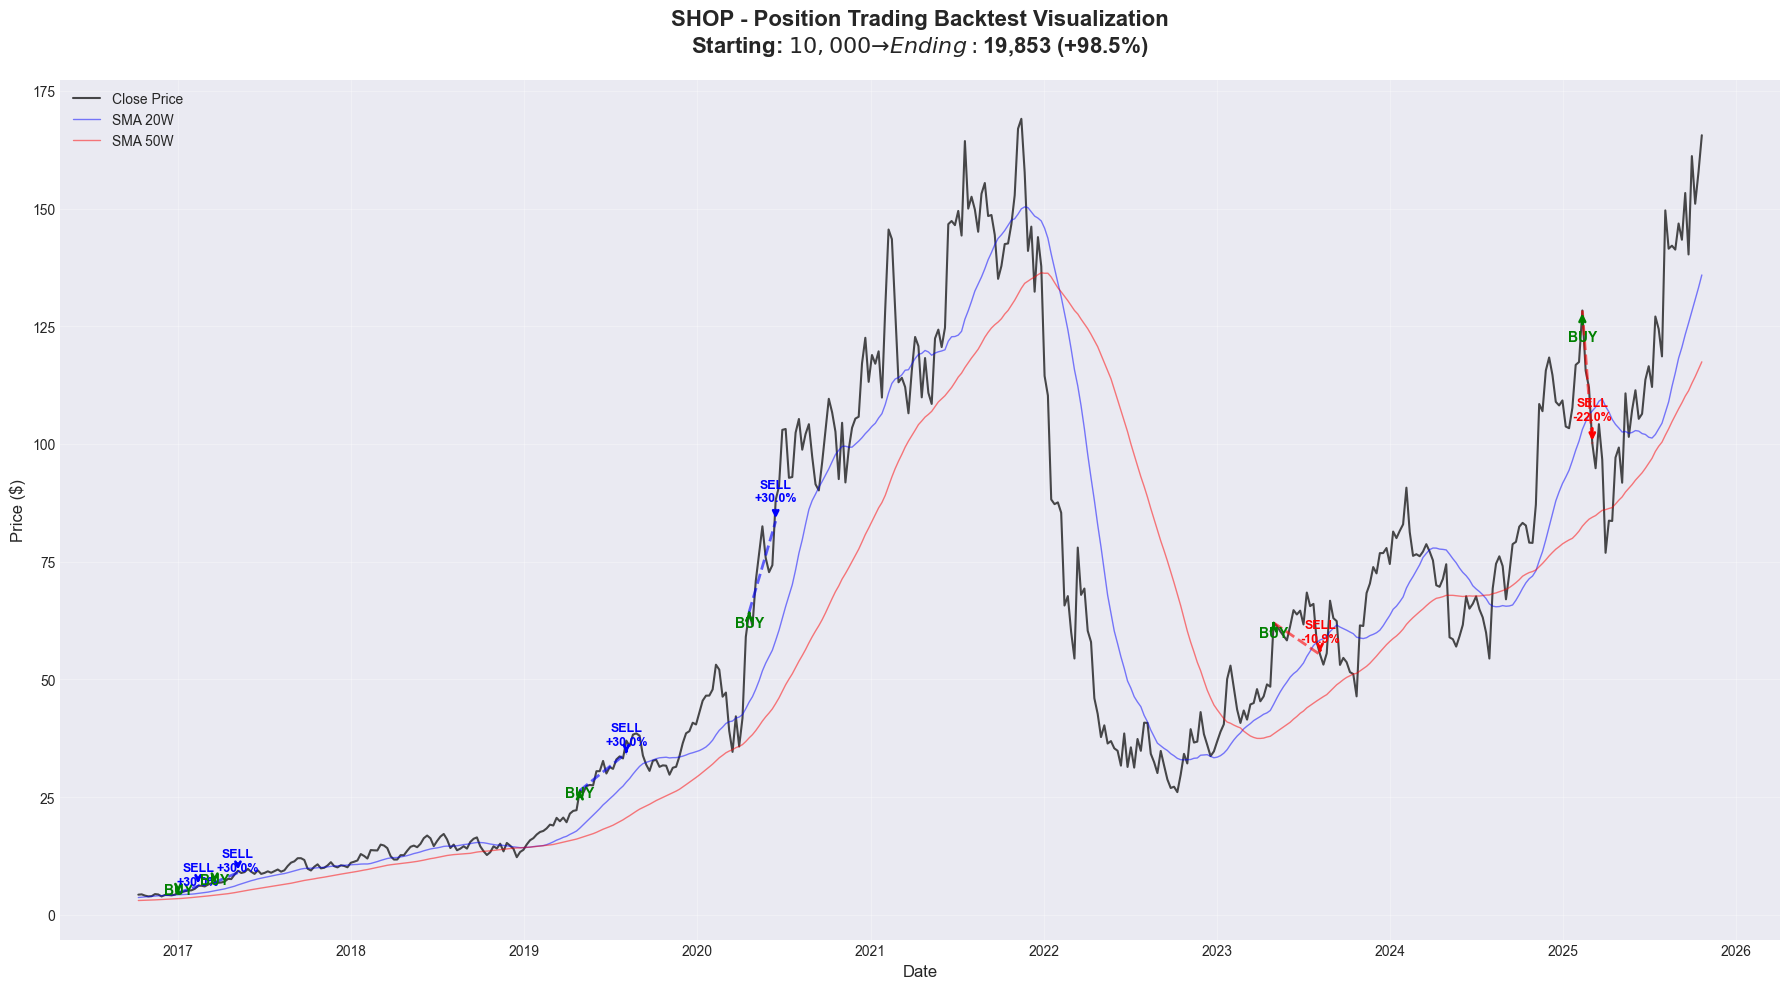




VISUAL BACKTEST: MSTR

Fetched 523 weeks of data for MSTR
Analyzing 472 weeks from 2016-10-10 to 2025-10-20

TRADE SUMMARY:

Trade 1: WIN ✓
  Entry:  2020-10-19 @ $18.43
  Exit:   2020-11-23 @ $23.96
  Return: +30.0% (Profit Target)
  Held:   5 weeks
  Capital: $13,000.00 (+3,000.00)

Trade 2: WIN ✓
  Entry:  2020-12-28 @ $38.85
  Exit:   2021-01-04 @ $50.51
  Return: +30.0% (Profit Target)
  Held:   1 weeks
  Capital: $16,900.00 (+3,900.00)

Trade 3: WIN ✓
  Entry:  2023-12-04 @ $59.94
  Exit:   2024-02-26 @ $77.92
  Return: +30.0% (Profit Target)
  Held:   12 weeks
  Capital: $21,970.00 (+5,070.00)

Trade 4: WIN ✓
  Entry:  2024-03-04 @ $142.56
  Exit:   2024-04-01 @ $151.50
  Return: +6.3% (Stop Loss)
  Held:   4 weeks
  Capital: $23,348.00 (+1,378.00)

FINAL RESULTS:
  Starting Capital: $10,000.00
  Ending Capital:   $23,348.00
  Total Return:     +133.5%
  Total Trades:     4

Chart saved to ../results/MSTR_backtest_visualization.png


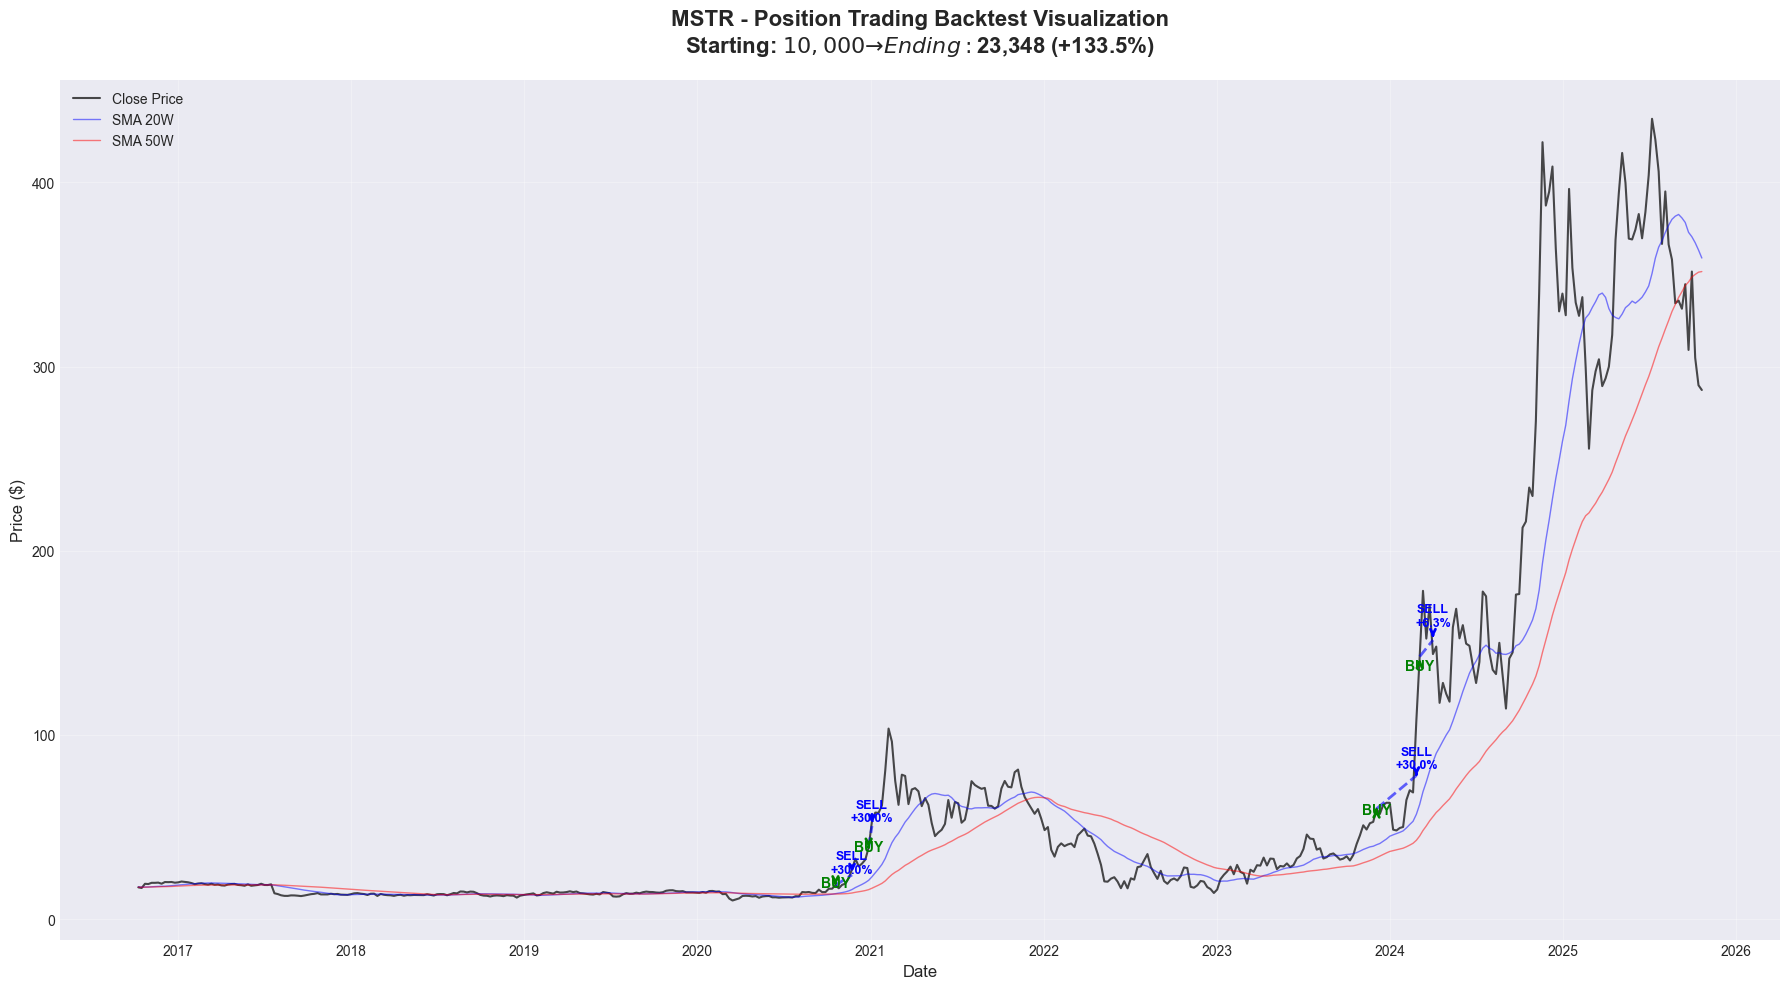




VISUAL BACKTEST: TSM

Fetched 523 weeks of data for TSM
Analyzing 472 weeks from 2016-10-10 to 2025-10-20

TRADE SUMMARY:

Trade 1: WIN ✓
  Entry:  2017-07-10 @ $30.09
  Exit:   2018-04-02 @ $35.21
  Return: +17.0% (Trend Break)
  Held:   38 weeks
  Capital: $11,702.07 (+1,702.07)

Trade 2: WIN ✓
  Entry:  2019-10-07 @ $44.22
  Exit:   2020-02-24 @ $48.51
  Return: +9.7% (Trend Break)
  Held:   20 weeks
  Capital: $12,837.73 (+1,135.66)

Trade 3: WIN ✓
  Entry:  2020-07-13 @ $60.84
  Exit:   2020-10-05 @ $79.10
  Return: +30.0% (Profit Target)
  Held:   12 weeks
  Capital: $16,689.05 (+3,851.32)

Trade 4: LOSS ✗
  Entry:  2023-05-22 @ $99.60
  Exit:   2023-08-07 @ $89.14
  Return: -10.5% (Trend Break)
  Held:   11 weeks
  Capital: $14,937.08 (-1,751.97)

Trade 5: WIN ✓
  Entry:  2024-01-15 @ $111.76
  Exit:   2024-05-06 @ $145.29
  Return: +30.0% (Profit Target)
  Held:   16 weeks
  Capital: $19,418.20 (+4,481.12)

Trade 6: LOSS ✗
  Entry:  2024-07-08 @ $184.67
  Exit:   2024-07-29 

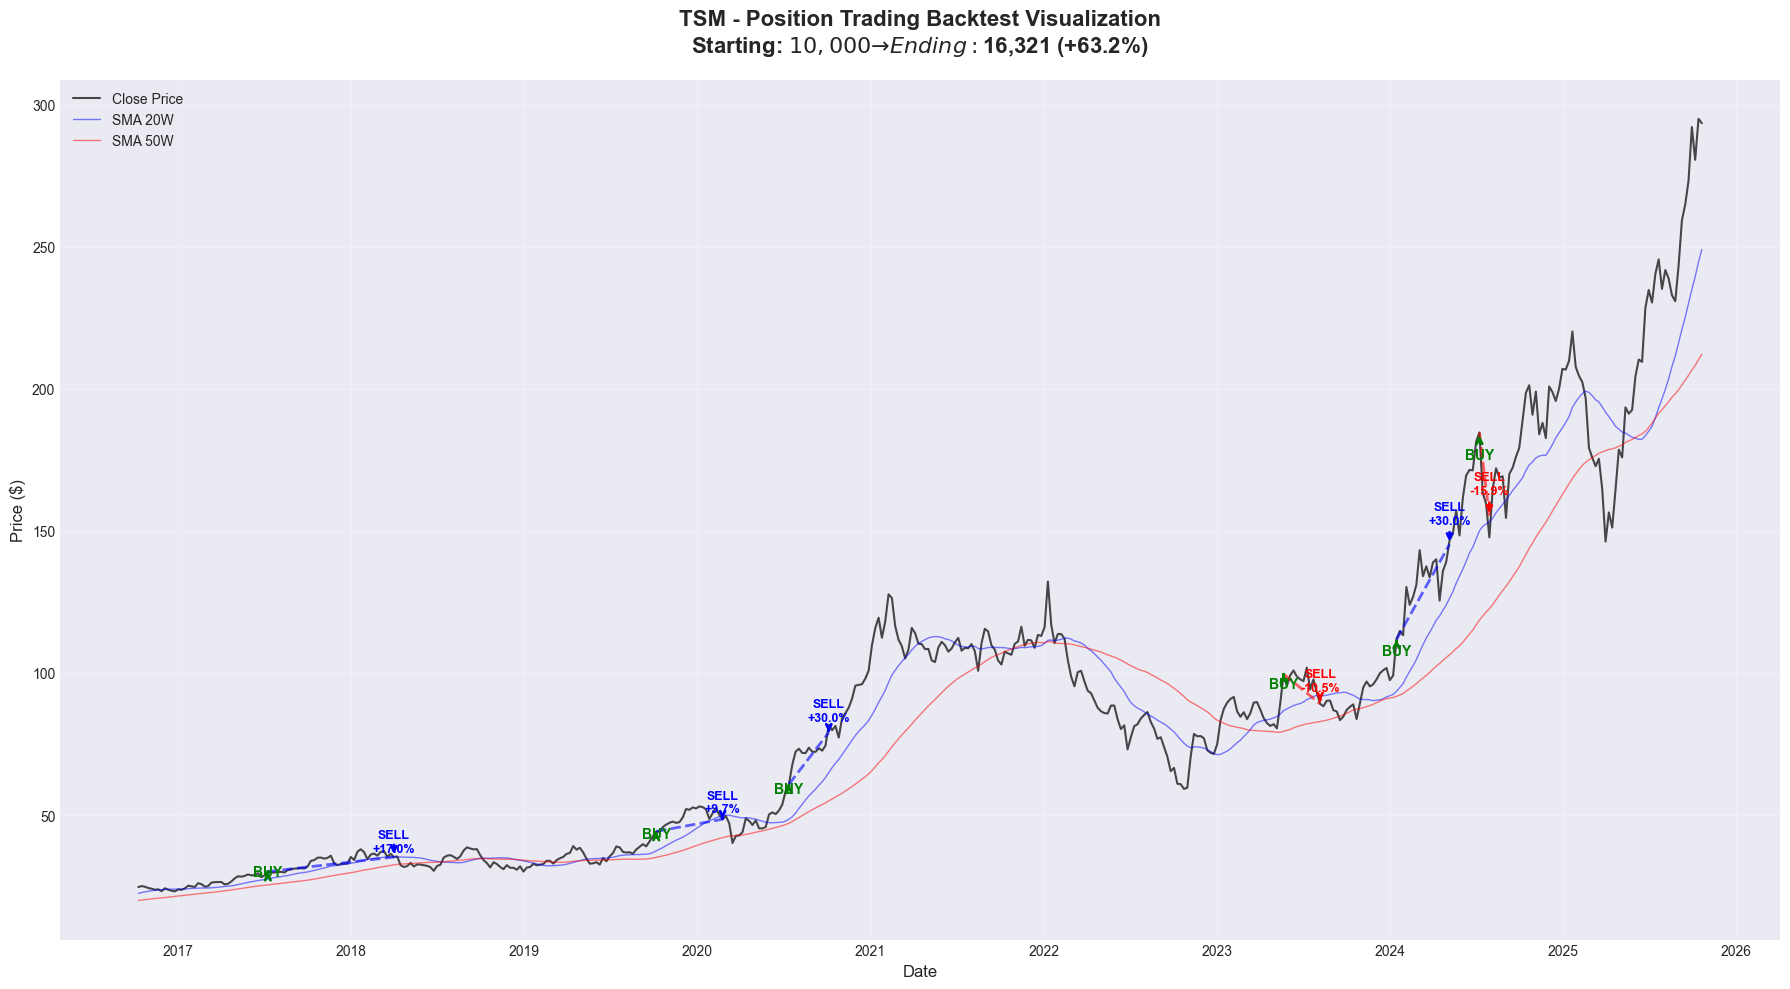




COMPARATIVE RESULTS (Starting $10,000 each):
SHOP  : $ 19,853.15  ( +98.5%)
MSTR  : $ 23,348.00  (+133.5%)
TSM   : $ 16,321.27  ( +63.2%)


In [30]:
def visualize_backtest_trades(ticker, save_chart=True):
    """
    Visualize all historical trades for a stock.
    Shows entry/exit points on price chart with profit/loss.
    """
    print(f'\n{"="*80}')
    print(f'VISUAL BACKTEST: {ticker}')
    print(f'{"="*80}\n')
    
    # Fetch full history
    df = fetch_weekly_data(ticker, period='10y')
    
    if df is None or df.empty:
        print(f'Failed to fetch data for {ticker}')
        return
    
    # Calculate indicators
    df = calculate_position_indicators(df, ticker=ticker)
    df = generate_entry_signal(df)
    df = df.dropna()
    
    if df.empty:
        print('Insufficient data')
        return
    
    print(f'Analyzing {len(df)} weeks from {df.index[0].date()} to {df.index[-1].date()}')
    
    # Simulate trades (same logic as backtest)
    trades = []
    in_position = False
    entry_price = 0
    entry_date = None
    entry_idx = 0
    
    for i in range(len(df)):
        current_date = df.index[i]
        current_bar = df.iloc[i]
        
        if not in_position:
            if current_bar['Entry_Signal']:
                in_position = True
                entry_price = current_bar['Close']
                entry_date = current_date
                entry_idx = i
                initial_stop = entry_price - (CONFIG['stop_loss_atr_mult'] * current_bar['ATR'])
                profit_target = entry_price * (1 + CONFIG['target_gain'])
        else:
            weeks_held = i - entry_idx
            current_price = current_bar['Close']
            
            position_high = df['Close'].iloc[entry_idx:i+1].max()
            trailing_stop_active = position_high >= entry_price * 1.20
            trailing_stop = position_high * (1 - 0.15) if trailing_stop_active else initial_stop
            stop_loss = max(initial_stop, trailing_stop)
            
            exit_reason = None
            exit_price = current_price
            
            if current_price >= profit_target:
                exit_reason = 'Profit Target'
                exit_price = profit_target
            elif current_price < stop_loss:
                exit_reason = 'Stop Loss'
                exit_price = stop_loss
            elif not current_bar['Trend_Bullish']:
                exit_reason = 'Trend Break'
            elif weeks_held >= 52:
                exit_reason = 'Time Exit'
            
            if exit_reason:
                exit_date = current_date
                return_pct = (exit_price - entry_price) / entry_price * 100
                
                trades.append({
                    'entry_date': entry_date,
                    'entry_price': entry_price,
                    'exit_date': exit_date,
                    'exit_price': exit_price,
                    'return_pct': return_pct,
                    'weeks_held': weeks_held,
                    'exit_reason': exit_reason,
                    'profit_loss': 'WIN' if return_pct > 0 else 'LOSS'
                })
                
                in_position = False
    
    if not trades:
        print('No trades generated')
        return
    
    # Print trade summary
    print(f'\nTRADE SUMMARY:')
    print(f'{"="*80}')
    
    starting_capital = 10000
    current_capital = starting_capital
    
    for i, trade in enumerate(trades, 1):
        profit_loss = (trade['exit_price'] - trade['entry_price']) / trade['entry_price']
        capital_change = current_capital * profit_loss
        current_capital += capital_change
        
        result_symbol = '✓' if trade['return_pct'] > 0 else '✗'
        
        print(f"\nTrade {i}: {trade['profit_loss']} {result_symbol}")
        print(f"  Entry:  {trade['entry_date'].date()} @ ${trade['entry_price']:.2f}")
        print(f"  Exit:   {trade['exit_date'].date()} @ ${trade['exit_price']:.2f}")
        print(f"  Return: {trade['return_pct']:+.1f}% ({trade['exit_reason']})")
        print(f"  Held:   {trade['weeks_held']} weeks")
        print(f"  Capital: ${current_capital:,.2f} ({capital_change:+,.2f})")
    
    total_return = (current_capital - starting_capital) / starting_capital * 100
    
    print(f'\n{"="*80}')
    print(f'FINAL RESULTS:')
    print(f'  Starting Capital: ${starting_capital:,.2f}')
    print(f'  Ending Capital:   ${current_capital:,.2f}')
    print(f'  Total Return:     {total_return:+.1f}%')
    print(f'  Total Trades:     {len(trades)}')
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Plot price
    ax.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1.5, alpha=0.7)
    
    # Plot moving averages
    ax.plot(df.index, df['SMA_20'], label='SMA 20W', color='blue', linewidth=1, alpha=0.5)
    ax.plot(df.index, df['SMA_50'], label='SMA 50W', color='red', linewidth=1, alpha=0.5)
    
    # Mark trades
    for trade in trades:
        entry_date = trade['entry_date']
        exit_date = trade['exit_date']
        entry_price = trade['entry_price']
        exit_price = trade['exit_price']
        
        # Buy arrow (green for all entries)
        ax.annotate('BUY', xy=(entry_date, entry_price),
                   xytext=(entry_date, entry_price * 0.95),
                   fontsize=10, fontweight='bold', color='green',
                   ha='center',
                   arrowprops=dict(arrowstyle='->', color='green', lw=2))
        
        # Sell arrow (red=loss, blue=win)
        color = 'blue' if trade['return_pct'] > 0 else 'red'
        label = f"{trade['return_pct']:+.1f}%"
        
        ax.annotate(f'SELL\n{label}', xy=(exit_date, exit_price),
                   xytext=(exit_date, exit_price * 1.05),
                   fontsize=9, fontweight='bold', color=color,
                   ha='center',
                   arrowprops=dict(arrowstyle='->', color=color, lw=2))
        
        # Draw line connecting entry to exit
        ax.plot([entry_date, exit_date], [entry_price, exit_price],
               color=color, linewidth=2, alpha=0.6, linestyle='--')
    
    ax.set_title(f'{ticker} - Position Trading Backtest Visualization\n'
                f'Starting: ${starting_capital:,.0f} → Ending: ${current_capital:,.0f} ({total_return:+.1f}%)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_chart:
        save_path = f'../results/{ticker}_backtest_visualization.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f'\nChart saved to {save_path}')
    
    plt.show()
    
    return current_capital, total_return


# Run visualization on top performers
print('VISUAL BACKTESTS - TOP PERFORMERS')
print('='*80)
print('This will show you EXACTLY where the system bought and sold\n')

# Visualize top 3 stocks
top_stocks = ['SHOP', 'MSTR', 'TSM']

results = {}
for stock in top_stocks:
    final_capital, total_return = visualize_backtest_trades(stock, save_chart=True)
    results[stock] = {'capital': final_capital, 'return': total_return}
    print('\n' + '='*80 + '\n')

# Summary comparison
print('\nCOMPARATIVE RESULTS (Starting $10,000 each):')
print('='*80)
for stock, result in results.items():
    print(f"{stock:6s}: ${result['capital']:>10,.2f}  ({result['return']:>+6.1f}%)")


---
## Quick Start Guide

**To analyze a single stock:**
1. Set `TICKER` in Cell 5
2. Run Cell 5 to see entry signal analysis
3. Run Cell 5 (second code block) to see chart

**To scan for opportunities:**
1. Customize `WATCHLIST` in Cell 1 if needed
2. Run Cell 7 to scan all stocks
3. Focus on stocks with Score > 60 and Entry_Signal = BUY

**To track positions:**
1. Add positions to `OPEN_POSITIONS` in Cell 6
2. Run Cell 6 to monitor exit signals

**To validate strategy:**
1. Set `BACKTEST_TICKER` in Cell 8
2. Run Cell 8 to see historical performance
3. Run Cell 8 (second block) for multi-stock validation

---

## Strategy Summary

**Entry: ALL criteria must be met**
- Breakout above 20-week high
- Bullish trend (20W MA > 50W MA)
- Strong trend (ADX > 25)
- Volume spike (>1.3x average)
- Near 52-week high (<5% away)

**Exit: ANY trigger closes position**
- Stop loss (entry - 2.5x ATR)
- Profit target (+30%)
- Trailing stop (15% below high after +20%)
- Trend break (close below 20W MA)
- Time exit (52 weeks)

**Position Sizing:**
- Risk 2% per trade
- Max 8 concurrent positions
- Calculate shares: (Account × 2%) / (Entry - Stop)

---

## Next Steps

1. **Paper trade** - Test strategy with virtual money first
2. **Optimize parameters** - Adjust ADX threshold, MA periods, targets based on backtests
3. **Add fundamentals** - Layer in revenue growth, earnings for extra confirmation
4. **Automate alerts** - Set up email/SMS when entry signals appear
5. **Build dashboard** - Create live monitoring interface

**Remember:**
- This is NOT financial advice
- Always validate signals with your own analysis
- Never risk more than you can afford to lose
- Past performance does not guarantee future results